In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("sleep_dataset.csv")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (23651, 5)


,Sleep_Duration,Stress_Level,Physical_Activity,Heart_Rate,Quality_of_Sleep
0,6.247241,3,52.436791,91.0,1.0
1,9.704286,6,72.783696,87.0,2.0
2,8.391964,2,91.803168,85.0,2.0
3,7.591951,8,112.086557,75.0,1.0
4,4.936112,4,50.033372,80.0,1.0


In [7]:
# Map Quality_of_Sleep to 3 classes (0,1,2)
df['Quality_of_Sleep'] = df['Quality_of_Sleep'].replace({
    1: 0,  # Poor
    2: 0,  # Poor
    3: 1,  # Average
    4: 2   # Good
})

print("Unique target classes:", df['Quality_of_Sleep'].unique())

# Features and target
X = df[['Sleep_Duration', 'Stress_Level', 'Physical_Activity', 'Heart_Rate']]
y = df['Quality_of_Sleep']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "sleep_scaler.pkl")

print("✅ Preprocessing completed successfully")


Unique target classes: [0 1]
✅ Preprocessing completed successfully


In [8]:
# Build ANN model
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
print("Training ANN model...")
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

# Save model
model.save("sleep_quality_ann_model.h5")
print("✅ ANN model trained and saved successfully")


Training ANN model...
Epoch 1/30
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9992 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0127
Epoch 2/30
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 5.9408e-04
Epoch 3/30
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 8.6349e-04 - val_accuracy: 1.0000 - val_loss: 2.0383e-04
Epoch 4/30
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 7.1788e-04 - val_accuracy: 1.0000 - val_loss: 1.2898e-04
Epoch 5/30
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 6.8358e-04 - val_accuracy: 1.0000 - val_loss: 7.2953e-05
Epoch 6/30
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 6.6468e-04 - val_accuracy: 1.0000 - val_loss: 4.5179e-05
Epoch 7/30
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 6.7696e-04 - val_accuracy: 1.0000 - val_loss: 4.1007e-05
Epoch 8/30
1065/1065 ━━━

✅ ANN model trained and saved successfully


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Classification Report ---
              precision    recall  f1-score   support

        Poor       1.00      1.00      1.00      4731
     Average       0.00      0.00      0.00         0
        Good       0.00      0.00      0.00         0

    accuracy                           1.00      4731
   macro avg       0.33      0.33      0.33      4731
weighted avg       1.00      1.00      1.00      4731



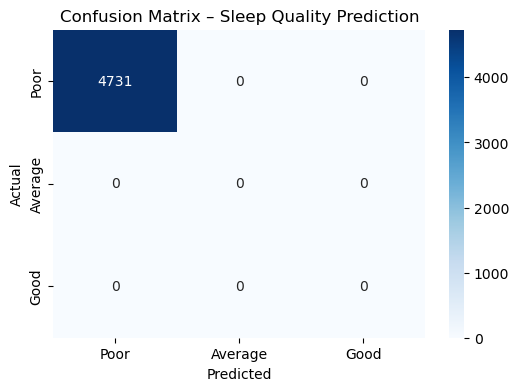

In [10]:
# Predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("\n--- Classification Report ---")
print(classification_report(
    y_test,
    y_pred,
    labels=[0, 1, 2],
    target_names=['Poor', 'Average', 'Good'],
    zero_division=0
))
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Poor', 'Average', 'Good'],
    yticklabels=['Poor', 'Average', 'Good']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Sleep Quality Prediction")
plt.show()


In [11]:
# Prediction function
def predict_sleep_quality(sleep_duration, stress_level, physical_activity, heart_rate):
    features = np.array([[sleep_duration, stress_level, physical_activity, heart_rate]])
    features_scaled = scaler.transform(features)
    
    prediction = model.predict(features_scaled)
    class_index = np.argmax(prediction)
    
    mapping = {0: "Poor", 1: "Average", 2: "Good"}
    return mapping[class_index]

# Gradio Interface
interface = gr.Interface(
    fn=predict_sleep_quality,
    inputs=[
        gr.Number(label="Sleep Duration (Hours)"),
        gr.Slider(1, 10, label="Stress Level"),
        gr.Number(label="Physical Activity (Minutes/Day)"),
        gr.Number(label="Heart Rate (BPM)")
    ],
    outputs=gr.Textbox(label="Predicted Sleep Quality"),
    title="Sleep Quality Prediction System (ANN)",
    description="Predicts sleep quality (Poor, Average, Good) using an Artificial Neural Network."
)

interface.launch(inline=True)


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
